In [26]:
import numpy as np
import cvxpy as cp
import random
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
from collections import deque

# plt.style.use('ggplot')

In [27]:
class KArmedLinearBandit(gym.Env):
    def __init__(self, k=10, d=5, reward_noise_sigma=1, seed=0):
        super().__init__()

        self.k = k
        self.d = d

        self.action_space = spaces.Discrete(self.k)
        self.observation_space = spaces.Discrete(1)

        self.reward_noise_sigma = reward_noise_sigma

        self._seed(seed)
        self.set_theta_action_vecs()

    def randomGenerator(self, d, K):

        vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=K)
        norms = np.linalg.norm(vecs, axis=1)
        return vecs / norms[:,np.newaxis]

    def set_theta_action_vecs(self):

        self.true_theta = self.randomGenerator(self.d, 1)[0]
        self.action_vecs = self.randomGenerator(self.d, self.k)
        self.best_possible_reward = np.max([np.dot(self.true_theta, a) for a in self.action_vecs])


    def _seed(self, seed=None):
#         self.np_random, seed = seeding.np_random(seed)
        random.seed(seed)
        np.random.seed(seed)
        super().reset(seed=seed)

    def step(self, action):
        assert self.action_space.contains(action), ('Selected action {} is invalid.'.format(action))

        action_vec = self.action_vecs[action]
        mean_reward = np.dot(action_vec, self.true_theta)

        reward = np.random.normal(mean_reward, scale = self.reward_noise_sigma) # get noisy reward

        return reward  # next_state, reward, done, info

    def reset(self, seed=None):
        if seed is not None:
            super().reset(seed=seed)
        self.set_theta_action_vecs()

In [28]:
class Expert(object):

    def __init__(self, theta_sample = 0, action_vecs = None, d=5, lamb = 10, beta = 15, N = 1000):

        self.theta_sample = theta_sample
        self.action_vecs = action_vecs
        self.d = d
        self.lamb = lamb
        self.beta = beta
        self.N = N

        self.vartheta = np.random.multivariate_normal(self.theta_sample,
                                                       np.diag(np.ones(self.d))/(self.lamb**2))

    def give_preference(self, actions):
        action_scores = []
        action_indices = []
        idx = 0
        for action in actions:
            score = np.exp(self.beta * np.dot(action, self.vartheta))
            action_scores.append(score)
            action_indices.append(idx)
            idx += 1

        action_scores = np.asarray(action_scores)

        probabilities = action_scores / np.sum(action_scores)

        preference = np.random.choice(action_indices, p = probabilities)

        return preference

    def generate_offline_dataset(self):

        num_actions = self.action_vecs.shape[0]

        dataset = []

        for _ in range(N):
            action_indices = random.sample(range(num_actions), 2)
            actions = [self.action_vecs[idx] for idx in action_indices]
            preference = self.give_preference(actions)

            datapoint = np.asarray([*action_indices, preference], dtype=object)
            dataset.append(datapoint)

        dataset = np.asarray(dataset)

        return dataset


def get_theta_sample(mu_0, sigma_0, d=5, size=1):
    if(size>1):
        return np.random.multivariate_normal(mu_0, sigma_0, size=size)
    else:
        return np.random.multivariate_normal(mu_0, sigma_0)

In [29]:
import numpy as np
from scipy.optimize import minimize

class WarmThompsonSampling():

    def __init__(self, d=5, k=10, lamb=10, beta=15, mu_0=0,
                 sigma_0=0, action_vecs=None, offline_dataset=None):

        self.name = 'warmTS'
        self.d = d
        self.k = k
        self.lamb = lamb
        self.beta = beta
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.action_vecs = action_vecs
        self.offline_dataset = offline_dataset

        self.online_dataset = []

    def get_online_perturbation(self):
        return np.random.normal(0, 1)  # L_1

    def get_offline_perturbation(self):
        return np.random.exponential(1)  # L_2

    def get_prior_perturbation(self):
        theta_dash = np.random.multivariate_normal(self.mu_0, self.sigma_0)
        vartheta_dash = np.random.multivariate_normal(self.mu_0, np.diag(np.ones(self.d)) / (self.lamb ** 2))
        return [theta_dash, vartheta_dash]  # L_3

    def log_sum_exp_approx(self, a, b, c):
        return np.logaddexp(0, a - b) + c

    def objective_function(self, x):
        theta_values, vartheta_values = x[:self.d], x[self.d:]

        L_1 = 0
        for a, r in self.online_dataset:
            L_1 += 1 / 2 * (r + self.get_online_perturbation() - self.action_vecs[a] @ theta_values) ** 2

        L_2 = 0
        for idx_a1, idx_a2, y in self.offline_dataset:
            a1_score = self.beta * (self.action_vecs[idx_a1] @ vartheta_values)
            a2_score = self.beta * (self.action_vecs[idx_a2] @ vartheta_values)
            preferred_action_score = a1_score if y == 0 else a2_score

            # Use logistic function approximation for log-sum-exp
            A_scores = self.log_sum_exp_approx(a1_score, a2_score, 0)

            L_2 += -1 * self.get_offline_perturbation() * (preferred_action_score + A_scores)

        L_3 = ((self.lamb ** 2) / 2) * (np.linalg.norm(theta_values - vartheta_values + self.get_prior_perturbation()[1]) ** 2)
        L_3 += (1 / 2) * np.linalg.norm(theta_values - self.mu_0 - self.get_prior_perturbation()[0]) ** 2

        return L_1 + L_2 + L_3

    def get_optimal_theta_vartheta(self):
        x0 = np.zeros(2 * self.d)  # Initial guess

        result = minimize(self.objective_function, x0, method='Powell', options={'maxiter': 5000}, tol=1e-6)

        if result.success:
            theta_optimal = result.x[:self.d]
            vartheta_optimal = result.x[self.d:]
            return theta_optimal, vartheta_optimal
        else:
            raise ValueError(f"Optimization failed: {result.message}")

    def take_action(self):
        theta_opt, vartheta_opt = self.get_optimal_theta_vartheta()
        action_idx = np.argmax([np.dot(theta_opt, a) for a in self.action_vecs])
        return action_idx

    def reset(self):
        self.online_dataset = []

In [30]:
class ThompsonSampling():

    def __init__(self, d=5, k=10, mu_0 = 0, sigma_0 = 0, action_vecs = None, reward_noise_sigma=0):

        self.name = 'TS'
        self.d = d
        self.k = k
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.mu = mu_0
        self.sigma = sigma_0
        self.action_vecs = action_vecs
        self.reward_noise_sigma = reward_noise_sigma

        self.online_dataset = []

    def update_parameters(self):
        # Page 17 : https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture9/lecture9.pdf
        if(len(self.online_dataset) > 0):
            action_idx, reward = self.online_dataset[-1] # take most recent a, r pair
            action = self.action_vecs[action_idx]

            new_sigma = np.linalg.inv(np.linalg.inv(self.sigma) + (action@action.T))
            new_mu = np.matmul(new_sigma, np.matmul(np.linalg.inv(self.sigma), self.mu) +
                              (reward + np.random.normal(0, self.reward_noise_sigma))*action)

            self.mu += new_mu
            self.sigma += new_sigma

    def take_action(self):

        self.update_parameters()
        theta_sample = np.random.multivariate_normal(self.mu, self.sigma)
        action_idx = np.argmax([np.dot(theta_sample, a) for a in self.action_vecs])

        return action_idx

    def reset(self):
        self.online_dataset = []
        self.mu = self.mu_0
        self.sigma = self.sigma_0


class LinUCB():
    def __init__(self, k, d, delta, T, action_vecs, lambda_reg=5, alpha=1):
        """
        T : Number of done actions for the calculation of thetas
        d : Dimension of action
        delta : Probability of theta non being within the high-confidence region
        lambda_reg : Regularization parameter of theta norm
        alpha : Scale factor of the exploration bonus
        """
        self.name = 'LinUCB'
        self.k = k
        self.T = T
        self.d = d
        self.action_vecs = action_vecs
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.b = np.zeros(self.d)
        self.V = self.lambda_reg*np.zeros(self.d)
        self.alpha = alpha
        self.used_arms = []
        self.UCBs = np.zeros(self.k)

        self.list_betas = [
          (np.sqrt(self.lambda_reg)
          + np.sqrt(2*np.log(1/self.delta)
          + self.d*np.log((self.lambda_reg*self.d+t)/(self.lambda_reg*self.d)))
          ) for t in range(self.T)]

        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        self.b = np.zeros(self.d)
        self.V = self.lambda_reg*np.zeros(self.d)
        self.used_arms = []

    def take_action(self):

        arms = self.action_vecs.copy()

        K, _ = arms.shape
        if self.t == 0 :
            chosen_arm = np.random.randint(0,high=K)
        else :
            self.UCBs = np.zeros(self.k)

        self.V = (np.array([
        np.outer(ai,ai.transpose()) for ai in self.used_arms
        ]).sum(axis=0)
        + self.lambda_reg*np.eye(self.d)
        )
        theta_hat = np.linalg.pinv(self.V).dot(self.b)
        self.UCBs = [
        (theta_hat.transpose()@arms[i]
        + self.alpha*self.list_betas[self.t]
        * np.sqrt(arms[i].transpose()@np.linalg.pinv(self.V)@arms[i])
        ) for i in range(K)]
        chosen_arm = np.argmax(self.UCBs)

        self.t += 1
        self.used_arms.append(arms[chosen_arm])

        return chosen_arm

    def receive_reward(self, chosen_arm, reward):
        self.b += reward*self.action_vecs[chosen_arm]


class LinUnif():
    def __init__(self, k, d, action_vecs):
        self.name = 'LinUnif'
        self.action_vecs = action_vecs

    def reset(self):
        pass

    def take_action(self):
        K,_ = self.action_vecs.shape
        return np.random.choice(K)

In [31]:
def train(env, agent, num_episodes = 3, T = 1000):

    ep_rewards = []
    ep_regrets = []
    avg_reward = 0
    print_every = num_episodes//min(num_episodes,10)

    for curr_ep in range(1, num_episodes+1):
#         env.reset()
        agent.reset()
        best_possible_reward = env.best_possible_reward
        cum_ep_rewards_list = []
        cum_ep_regrets_list = []

        cum_ep_reward = 0
        cum_ep_regret = 0

        for t in range(1, T+1):
            action = agent.take_action()
            reward = env.step(action)

            if(agent.name == 'LinUCB'):
                agent.receive_reward(action, reward)

            cum_ep_reward += reward
            cum_ep_regret += (best_possible_reward - reward)

            cum_ep_rewards_list.append(cum_ep_reward)
            cum_ep_regrets_list.append(cum_ep_regret)

            if(agent.name not in ['LinUCB', 'LinUnif']):
               agent.online_dataset.append([action, reward])


        ep_rewards.append(cum_ep_rewards_list)
        ep_regrets.append(cum_ep_regrets_list)

        avg_reward = (avg_reward*(curr_ep-1) + cum_ep_reward) / curr_ep

#         if(curr_ep%print_every == 0):
#             print('Episode {} \t Cum Reward {:.3f} \t Avg Reward {:.3f}'.format(curr_ep,cum_ep_reward,avg_reward))

    return np.asarray(ep_rewards), np.asarray(ep_regrets)

def plot(agent_reward_regret_dict, T):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    x_values = np.arange(T)

    for agent in agent_reward_regret_dict:
        ep_rewards = agent_reward_regret_dict[agent][0]
        mean_line = np.mean(ep_rewards, axis=0)
        std_deviation = np.std(ep_rewards, axis=0)
        ax1.plot(x_values, mean_line, label=agent)
        ax1.fill_between(x_values, mean_line - std_deviation, mean_line + std_deviation, alpha=0.2)

        ep_regrets = agent_reward_regret_dict[agent][1]
        mean_line = np.mean(ep_regrets, axis=0)
        std_deviation = np.std(ep_regrets, axis=0)
        ax2.plot(x_values, mean_line, label=agent)
        ax2.fill_between(x_values, mean_line - std_deviation, mean_line + std_deviation, alpha=0.2)


    ax1.set_ylabel('Cumulative Reward')
    ax2.set_xlabel('Time')
    ax1.set_title('Cumulative Reward Comparison')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Regret')
    ax2.set_title('Cumulative Regret Comparison')

    ax1.legend()
    ax2.legend()

    plt.show()

In [32]:
d = 2
k = 8
lamb = 10
beta = 15
N = 10
T = 100
num_episodes = 100

#LinUCB
delta = 0.1

reward_noise_sigma = 1

env = KArmedLinearBandit(k, d, reward_noise_sigma)
action_vecs = env.action_vecs

mu_0 = np.zeros(d)
sigma_0 = np.diag(np.ones(d))
theta_sample = get_theta_sample(mu_0, sigma_0, d, 1)

expert = Expert(theta_sample, action_vecs, d, lamb, beta, N)
offline_dataset = expert.generate_offline_dataset() # action_1_num, action_2_num, 0 or 1 (for action 1 or 2)

In [33]:
agents = [
           'warmTS',
#           'TS',
          'LinUCB-lamb:0.5',
          'LinUCB-lamb:5.0',
          'LinUnif',
         ]

agent_reward_regret_dict = {}

for agent_name in agents:
    if(agent_name == 'warmTS'):
        agent = WarmThompsonSampling(d, k, lamb, beta, mu_0, sigma_0, action_vecs, offline_dataset)
    elif(agent_name == 'TS'):
        agent = ThompsonSampling(d, k, mu_0, sigma_0, action_vecs, reward_noise_sigma)
    elif(agent_name == 'LinUCB-lamb:0.5'):
        agent = LinUCB(k, d, delta, T, action_vecs, 0.5)
    elif(agent_name == 'LinUCB-lamb:5.0'):
        agent = LinUCB(k, d, delta, T, action_vecs, 5.0)
    elif(agent_name == 'LinUnif'):
        agent = LinUnif(k, d, action_vecs)
    print('######### Agent: {} #########'.format(agent_name))
    ep_rewards, ep_regrets = train(env, agent, num_episodes, T)
    agent_reward_regret_dict[agent_name] = [ep_rewards, ep_regrets]
    print('\n\n')

######### Agent: warmTS #########



######### Agent: LinUCB-lamb:0.5 #########



######### Agent: LinUCB-lamb:5.0 #########



######### Agent: LinUnif #########





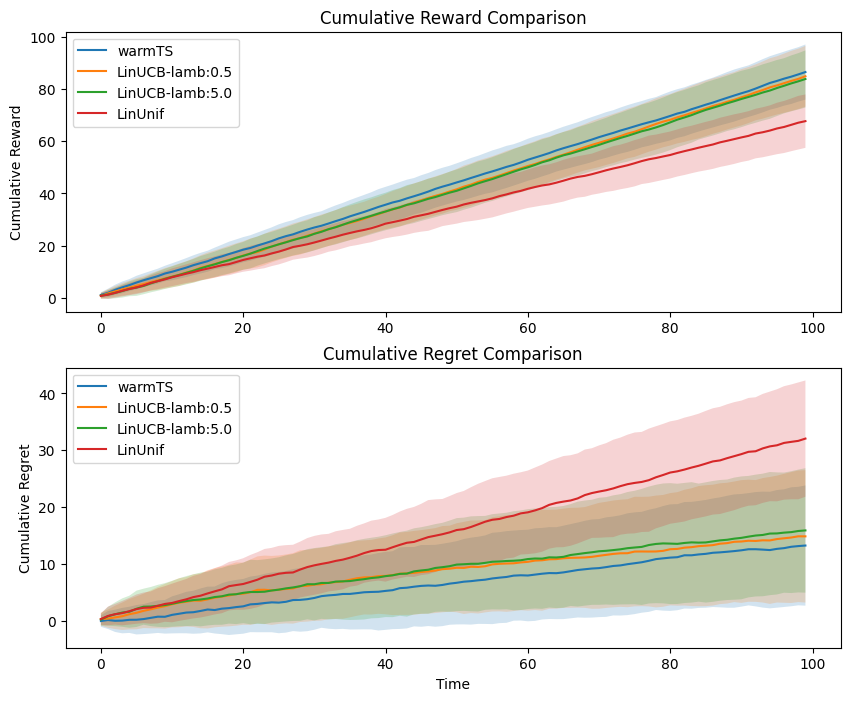

In [34]:
plot(agent_reward_regret_dict, T)